# Caustiques

In [1]:
%pip install -q -U -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
# import cv2
from tqdm.auto import trange, tqdm
import matplotlib
# import matplotlib.gridspec as gs
from matplotlib.gridspec import SubplotParams
import numpy as np
from scipy import ndimage
# from scipy.ndimage import zoom
matplotlib.__version__

'3.10.7'

In [3]:
import os 
from IPython import get_ipython
ip = get_ipython()
# print(ip.user_ns)
study_name = None
if '__vsc_ipynb_file__' in ip.user_ns:
    # https://github.com/msm1089/ipynbname/issues/17
    study_name = os.path.split(os.path.basename(ip.user_ns['__vsc_ipynb_file__']))[1]
elif '__file__' in ip.user_ns:
    study_name = ip.user_ns['__file__']
else:
    import ipynbname
    study_name = ipynbname.name()
study_name = study_name.replace('.ipynb', '')
study_name

'2025-10-28_copernicus'

In [4]:
fname = 'cmems_obs-sl_eur_phy-ssh_nrt_allsat-l4-duacs-0.0625deg_P1D_1761719834416.nc'

In [10]:
%pip install xarray netCDF4 matplotlib cartopy


Note: you may need to restart the kernel to use updated packages.


In [11]:
import xarray as xr
import matplotlib.pyplot as plt

# Read the NetCDF file
ds = xr.open_dataset(fname)

# Explore the dataset structure
print("=== Dataset Overview ===")
print(ds)

print("\n=== Variables in the file ===")
print(list(ds.data_vars))

print("\n=== Dimensions ===")
print(ds.dims)

print("\n=== Coordinates ===")
print(ds.coords)


=== Dataset Overview ===
<xarray.Dataset> Size: 5MB
Dimensions:    (time: 486, latitude: 44, longitude: 54)
Coordinates:
  * time       (time) datetime64[ns] 4kB 2024-07-01 2024-07-02 ... 2025-10-29
  * latitude   (latitude) float32 176B 40.09 40.16 40.22 ... 42.66 42.72 42.78
  * longitude  (longitude) float32 216B 4.531 4.594 4.656 ... 7.719 7.781 7.844
Data variables:
    sla        (time, latitude, longitude) float32 5MB ...
Attributes:
    Conventions:       CF-1.11
    title:             NRT merged all satellites European Seas Gridded SSALTO...
    institution:       CLS, CNES
    source:            Altimetry measurements
    history:           2025-05-02 14:08:33Z: Creation
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        http://marine.copernicus.eu
    comment:           Sea Surface Height measured by Altimetry and derived v...
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  SEALEVEL_EUR_PH

In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs  # Fixed import
import cartopy.feature as cfeature

# Read the file
ds = xr.open_dataset(fname)

print("File contains these variables:", list(ds.data_vars))

# Quick overview plot
if 'adt' in ds:
    # Simple plot
    ds['adt'].isel(time=0).plot(cmap='RdBu_r', figsize=(10, 6))
    plt.title('Sea Surface Height - First Time Step')
    plt.show()
    
    # Map plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
    ds['adt'].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), 
                               cmap='RdBu_r', vmin=-0.2, vmax=0.2)
    
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent([-6, 36, 30, 46])
    ax.gridlines(draw_labels=True)
    plt.title('Mediterranean Sea Surface Height')
    plt.show()

# Close the dataset
ds.close()


File contains these variables: ['sla']


In [15]:
import xarray as xr
import matplotlib.pyplot as plt

# Read the file
ds = xr.open_dataset(fname)


print("File contains these variables:", list(ds.data_vars))

# Basic plot without cartopy
if 'adt' in ds:
    plt.figure(figsize=(12, 8))
    ds['adt'].isel(time=0).plot(cmap='RdBu_r')
    plt.title('Sea Surface Height - Mediterranean Sea')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Time series at specific point
if 'adt' in ds:
    # Select a point (adjust coordinates as needed)
    point_data = ds['adt'].sel(
        longitude=18.0, 
        latitude=38.0, 
        method='nearest'
    )
    
    plt.figure(figsize=(12, 6))
    point_data.plot()
    plt.title('Sea Surface Height Time Series')
    plt.ylabel('Height (meters)')
    plt.grid(True)
    plt.show()

ds.close()


File contains these variables: ['sla']


In [16]:
# Common variable names in Copernicus data
possible_ssh_vars = ['adt', 'sla', 'ssh', 'sea_surface_height', 'zos']

print("=== SEA SURFACE HEIGHT VARIABLES FOUND ===")
for var in possible_ssh_vars:
    if var in ds.data_vars:
        print(f"✓ {var}: {ds[var].attrs.get('long_name', 'No description')}")
        print(f"  Units: {ds[var].attrs.get('units', 'Not specified')}")


=== SEA SURFACE HEIGHT VARIABLES FOUND ===
✓ sla: Sea level anomaly
  Units: m


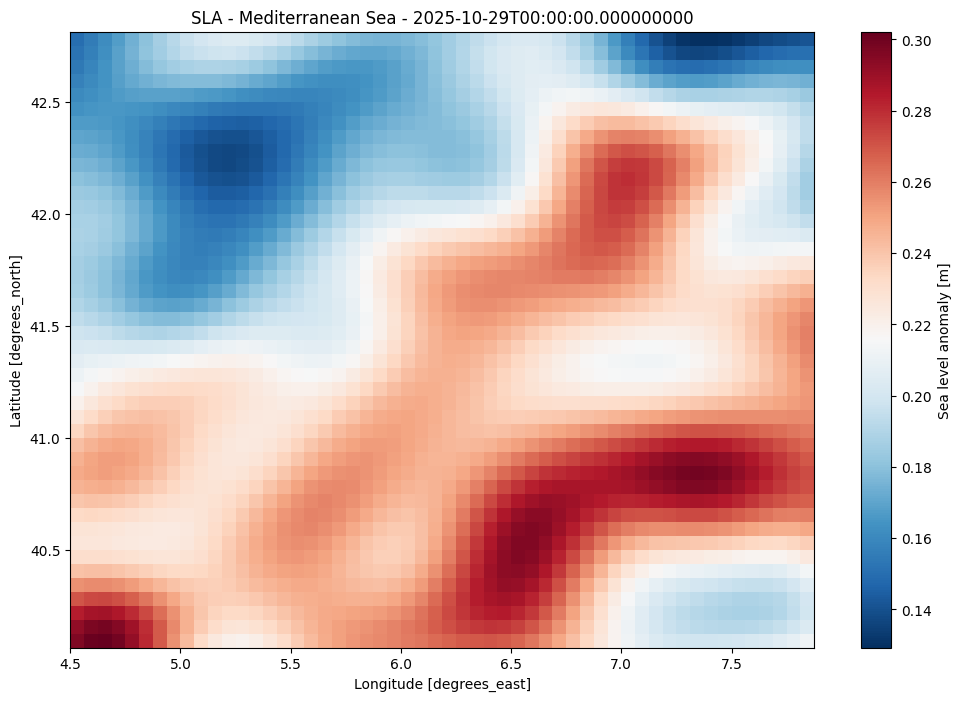

In [18]:
import matplotlib.pyplot as plt

# Choose the appropriate variable name from what you found
ssh_var = 'sla'  # or 'sla', 'ssh', etc.

if ssh_var in ds.data_vars:
    # Plot the most recent time step
    latest_time = ds.time.max()
    ssh_data = ds[ssh_var].sel(time=latest_time, method='nearest')
    
    plt.figure(figsize=(12, 8))
    ssh_data.plot(cmap='RdBu_r')
    plt.title(f'{ssh_var.upper()} - Mediterranean Sea - {latest_time.values}')
    plt.show()


In [40]:

if ssh_var in ds.data_vars:
    # Get the data as numpy array with time as last dimension
    data_array = ds[ssh_var].values  # This gives (time, lat, lon) or similar
    
    # Check the current dimension order
    print("Original dimension order:", ds[ssh_var].dims)
    print("Original shape:", data_array.shape)
    
    # Transpose to make time the last dimension
    dims = ds[ssh_var].dims
    if dims[0] == 'time':  # If time is first dimension
        data_transposed = np.transpose(data_array, (1, 2, 0))  # (lat, lon, time)
    elif dims[-1] == 'time':  # If time is already last
        data_transposed = data_array  # No need to transpose
    else:
        # General case: find time index and move it to last position
        time_idx = dims.index('time')
        new_order = [i for i in range(len(dims)) if i != time_idx] + [time_idx]
        data_transposed = np.transpose(data_array, new_order)
    
    print("Final shape (time as last dimension):", data_transposed.shape)


Original dimension order: ('time', 'latitude', 'longitude')
Original shape: (486, 44, 54)
Final shape (time as last dimension): (44, 54, 486)


In [41]:
data_transposed.mean(), data_transposed.std(), data_transposed.min(), data_transposed.max()

(np.float32(0.5000001),
 np.float32(0.12028646),
 np.float32(0.0),
 np.float32(0.9031961))

In [42]:
data_transposed -= data_transposed.mean()


In [43]:
data_transposed.mean(), data_transposed.std(), data_transposed.min(), data_transposed.max()

(np.float32(-1.2326106e-07),
 np.float32(0.12028646),
 np.float32(-0.5000001),
 np.float32(0.40319598))

In [44]:
data_transposed /= np.abs(data_transposed).max()

In [45]:
data_transposed.mean(), data_transposed.std(), data_transposed.min(), data_transposed.max()

(np.float32(-2.4102505e-07),
 np.float32(0.24057284),
 np.float32(-1.0),
 np.float32(0.8063918))

In [46]:
data_transposed /= 2
data_transposed += .5

In [47]:
data_transposed.mean(), data_transposed.std(), data_transposed.min(), data_transposed.max()

(np.float32(0.5),
 np.float32(0.12028643),
 np.float32(0.0),
 np.float32(0.90319586))

In [48]:
data_transposed = (data_transposed*(2**8-1)).astype(np.uint8)

In [49]:
data_transposed.mean(), data_transposed.std(), data_transposed.min(), data_transposed.max()

(np.float64(127.0000831358856),
 np.float64(30.67446260177208),
 np.uint8(0),
 np.uint8(230))

In [51]:
import imageio
def make_mp4(moviename, frames, fps):
    with imageio.v2.get_writer(
        moviename,
        format='FFmpeg', 
        mode='I',
        # format='av', 
        fps=fps,
        # pixelformat=pix_fmt
        # codec='ffv1',  # Use FFV1 for lossless compression
        ) as writer:
        for i_frame in trange(frames.shape[-1], desc='Generating movie'):
            # Append the frame to the video writer
            writer.append_data(frames[..., i_frame])
    return moviename

moviename = study_name + '.mp4'
moviename = make_mp4(moviename, data_transposed, fps=5)



Generating movie:   0%|          | 0/486 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (54, 44) to (64, 48) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
